In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import time

from tensorflow.keras.utils import image_dataset_from_directory
from keras import Sequential,layers
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten,BatchNormalization
os.listdir('../input')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

['cat-and-dog']

## Loading Image Dataset 🔃

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (128,128)

In [3]:
train = image_dataset_from_directory('../input/cat-and-dog/training_set/training_set',batch_size=BATCH_SIZE,image_size=IMG_SIZE,subset='training',validation_split=0.1,seed=123)
validation = image_dataset_from_directory('../input/cat-and-dog/training_set/training_set',batch_size=BATCH_SIZE,image_size=IMG_SIZE,subset='validation',validation_split=0.1,seed=123)
test = image_dataset_from_directory('../input/cat-and-dog/test_set/test_set',batch_size=BATCH_SIZE,image_size=IMG_SIZE)

Found 8005 files belonging to 2 classes.
Using 7205 files for training.
Found 8005 files belonging to 2 classes.
Using 800 files for validation.
Found 2023 files belonging to 2 classes.


In [4]:
for image_batch,label_batch in train:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(32, 128, 128, 3)
(32,)


In [5]:
type(train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [6]:
class_names = train.class_names
class_names

['cats', 'dogs']

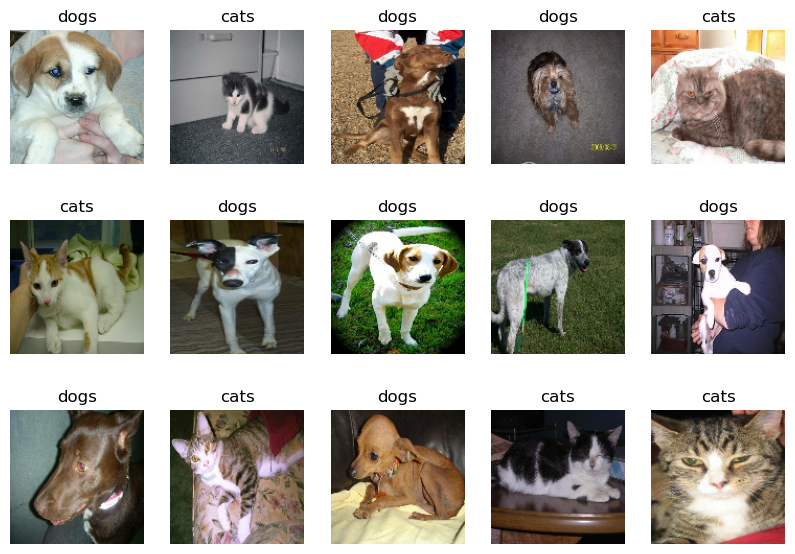

In [7]:
plt.figure(figsize=(10,7))
for image,label in train.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

## Rescaling images

In [8]:
train = train.map(lambda x,y:(x/255,y))
test = test.map(lambda x,y:(x/255,y))
validation = validation.map(lambda x,y:(x/255,y))

In [9]:
for image,_ in train.take(1):
    print(tf.reduce_max(image))
    print(tf.reduce_min(image))

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


## Configure the dataset for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test = test.cache().prefetch(buffer_size = AUTOTUNE)
validation = validation.cache().prefetch(buffer_size = AUTOTUNE)

## Data Augmentation

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(128,128,3)),
    layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
  ]
)

## A basic Keras CNN model

In [12]:
cnn = Sequential()

cnn.add(data_augmentation)

cnn.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'))
cnn.add(MaxPooling2D(padding='same',pool_size=2,strides=2))

cnn.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
cnn.add(MaxPooling2D(padding='same',pool_size=2,strides=2))

cnn.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
cnn.add(MaxPooling2D(padding='same',pool_size=2,strides=2))

cnn.add(Dropout(0.2))
cnn.add(BatchNormalization())
cnn.add(Flatten())

cnn.add(Dense(units=128,activation='relu'))
cnn.add(Dense(units=128,activation='relu'))
cnn.add(Dense(units=32,activation='relu'))
cnn.add(Dense(units=1,activation='sigmoid',name='output'))

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)      

In [13]:
ls = keras.losses.BinaryCrossentropy()
op = keras.optimizers.Adam()
cnn.compile(optimizer=op,loss=ls,metrics=['accuracy'])

## Model Training 

In [14]:
start_time = time.time()
hist = cnn.fit(train,epochs=25,validation_data=validation)
end_time = time.time() 

Epoch 1/25


2023-09-20 13:50:01.972574: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


226/226 [==============================] - 40s 43ms/step - loss: 0.6877 - accuracy: 0.5939 - val_loss: 0.6452 - val_accuracy: 0.6263
Epoch 2/25
226/226 [==============================] - 4s 19ms/step - loss: 0.6280 - accuracy: 0.6523 - val_loss: 0.6409 - val_accuracy: 0.6525
Epoch 3/25
226/226 [==============================] - 4s 19ms/step - loss: 0.6040 - accuracy: 0.6729 - val_loss: 0.7395 - val_accuracy: 0.5688
Epoch 4/25
226/226 [==============================] - 4s 19ms/step - loss: 0.5897 - accuracy: 0.6823 - val_loss: 0.6008 - val_accuracy: 0.6575
Epoch 5/25
226/226 [==============================] - 4s 19ms/step - loss: 0.5725 - accuracy: 0.7002 - val_loss: 0.5704 - val_accuracy: 0.7038
Epoch 6/25
226/226 [==============================] - 4s 19ms/step - loss: 0.5662 - accuracy: 0.7048 - val_loss: 0.6098 - val_accuracy: 0.6562
Epoch 7/25
226/226 [==============================] - 4s 19ms/step - loss: 0.5419 - accuracy: 0.7235 - val_loss: 0.7588 - val_accuracy: 0.6425
Epoch 8/2

In [15]:
print(f'Total time for training {(end_time-start_time)} seconds') 

Total time for training 146.72937440872192 seconds
